In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
import scipy.stats
import networkx as nx
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io



In [2]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



spotId  Dendritic cells      Mac4  Stromal cells  NK cells  \
0  AAACAAGTATCTCCCA.1         0.087213  0.113186       0.270488  0.096431   
1  AAACACCAATAACTGC.1         0.159247  0.129071       0.105884  0.002606   
2  AAACAGCTTTCAGAAG.1         0.042437  0.128286       0.329050  0.064440   
3  AAACAGGGTCTATATT.1         0.038153  0.094966       0.294255  0.055503   
4  AAACAGTGTTCCTGGG.1         0.000020  0.256841       0.323585  0.003329   

       Mac2  Monocytes   T cells      Mac5      Mac3      Mac1   B cells   key  
0  0.057255   0.083130  0.047384  0.163491  0.049659  0.006606  0.025157  HFD8  
1  0.084753   0.088446  0.016601  0.302068  0.046115  0.038813  0.026395  HFD8  
2  0.050805   0.049080  0.052493  0.100578  0.065773  0.025274  0.091783  HFD8  
3  0.061959   0.060107  0.048176  0.127678  0.099188  0.040547  0.079468  HFD8  
4  0.015668   0.010229  0.002518  0.222850  0.000587  0.000737  0.163636  HFD8

In [3]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64



spotId            x            y    key
0  AAACATTTCCCGGATT.1  1139.783401  1365.804581  HFD14
1  AAACCGGGTAGGTACC.1   468.056902  1045.415505  HFD14
2  AAACCGTTCGTCCAGG.1   604.524374  1214.452428  HFD14
3  AAACCTAAGCAGCCGG.1  1003.708924  1433.743571  HFD14
4  AAACCTCATGAAGTTG.1   380.369919   960.970730  HFD14

In [4]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


spotId            x            y    key  Dendritic cells  \
0  AAACATTTCCCGGATT.1  1139.783401  1365.804581  HFD14     3.468007e-02   
2  AAACCGGGTAGGTACC.1   468.056902  1045.415505  HFD14     1.280364e-03   
4  AAACCGTTCGTCCAGG.1   604.524374  1214.452428  HFD14     3.752028e-04   
6  AAACCTAAGCAGCCGG.1  1003.708924  1433.743571  HFD14     1.198581e-07   
8  AAACCTCATGAAGTTG.1   380.369919   960.970730  HFD14     1.377525e-02   

       Mac4  Stromal cells  NK cells      Mac2  Monocytes   T cells      Mac5  \
0  0.007548       0.409201  0.170860  0.004757   0.041542  0.055275  0.219997   
2  0.088368       0.187514  0.019633  0.028867   0.129969  0.040070  0.450618   
4  0.004256       0.283055  0.187004  0.021560   0.108340  0.044845  0.310869   
6  0.009084       0.239973  0.043516  0.004948   0.057287  0.052469  0.558332   
8  0.029749       0.216199  0.122802  0.053188   0.158933  0.041466  0.234411   

       Mac3      Mac1   B cells  
0  0.010912  0.004188  0.041040  
2  0.008903  0.013757  0.031021  
4  0.003200  0.004016  0.032480  
6  0.000064  0.023214  0.011113  
8  0.043126  0.037127  0.049224

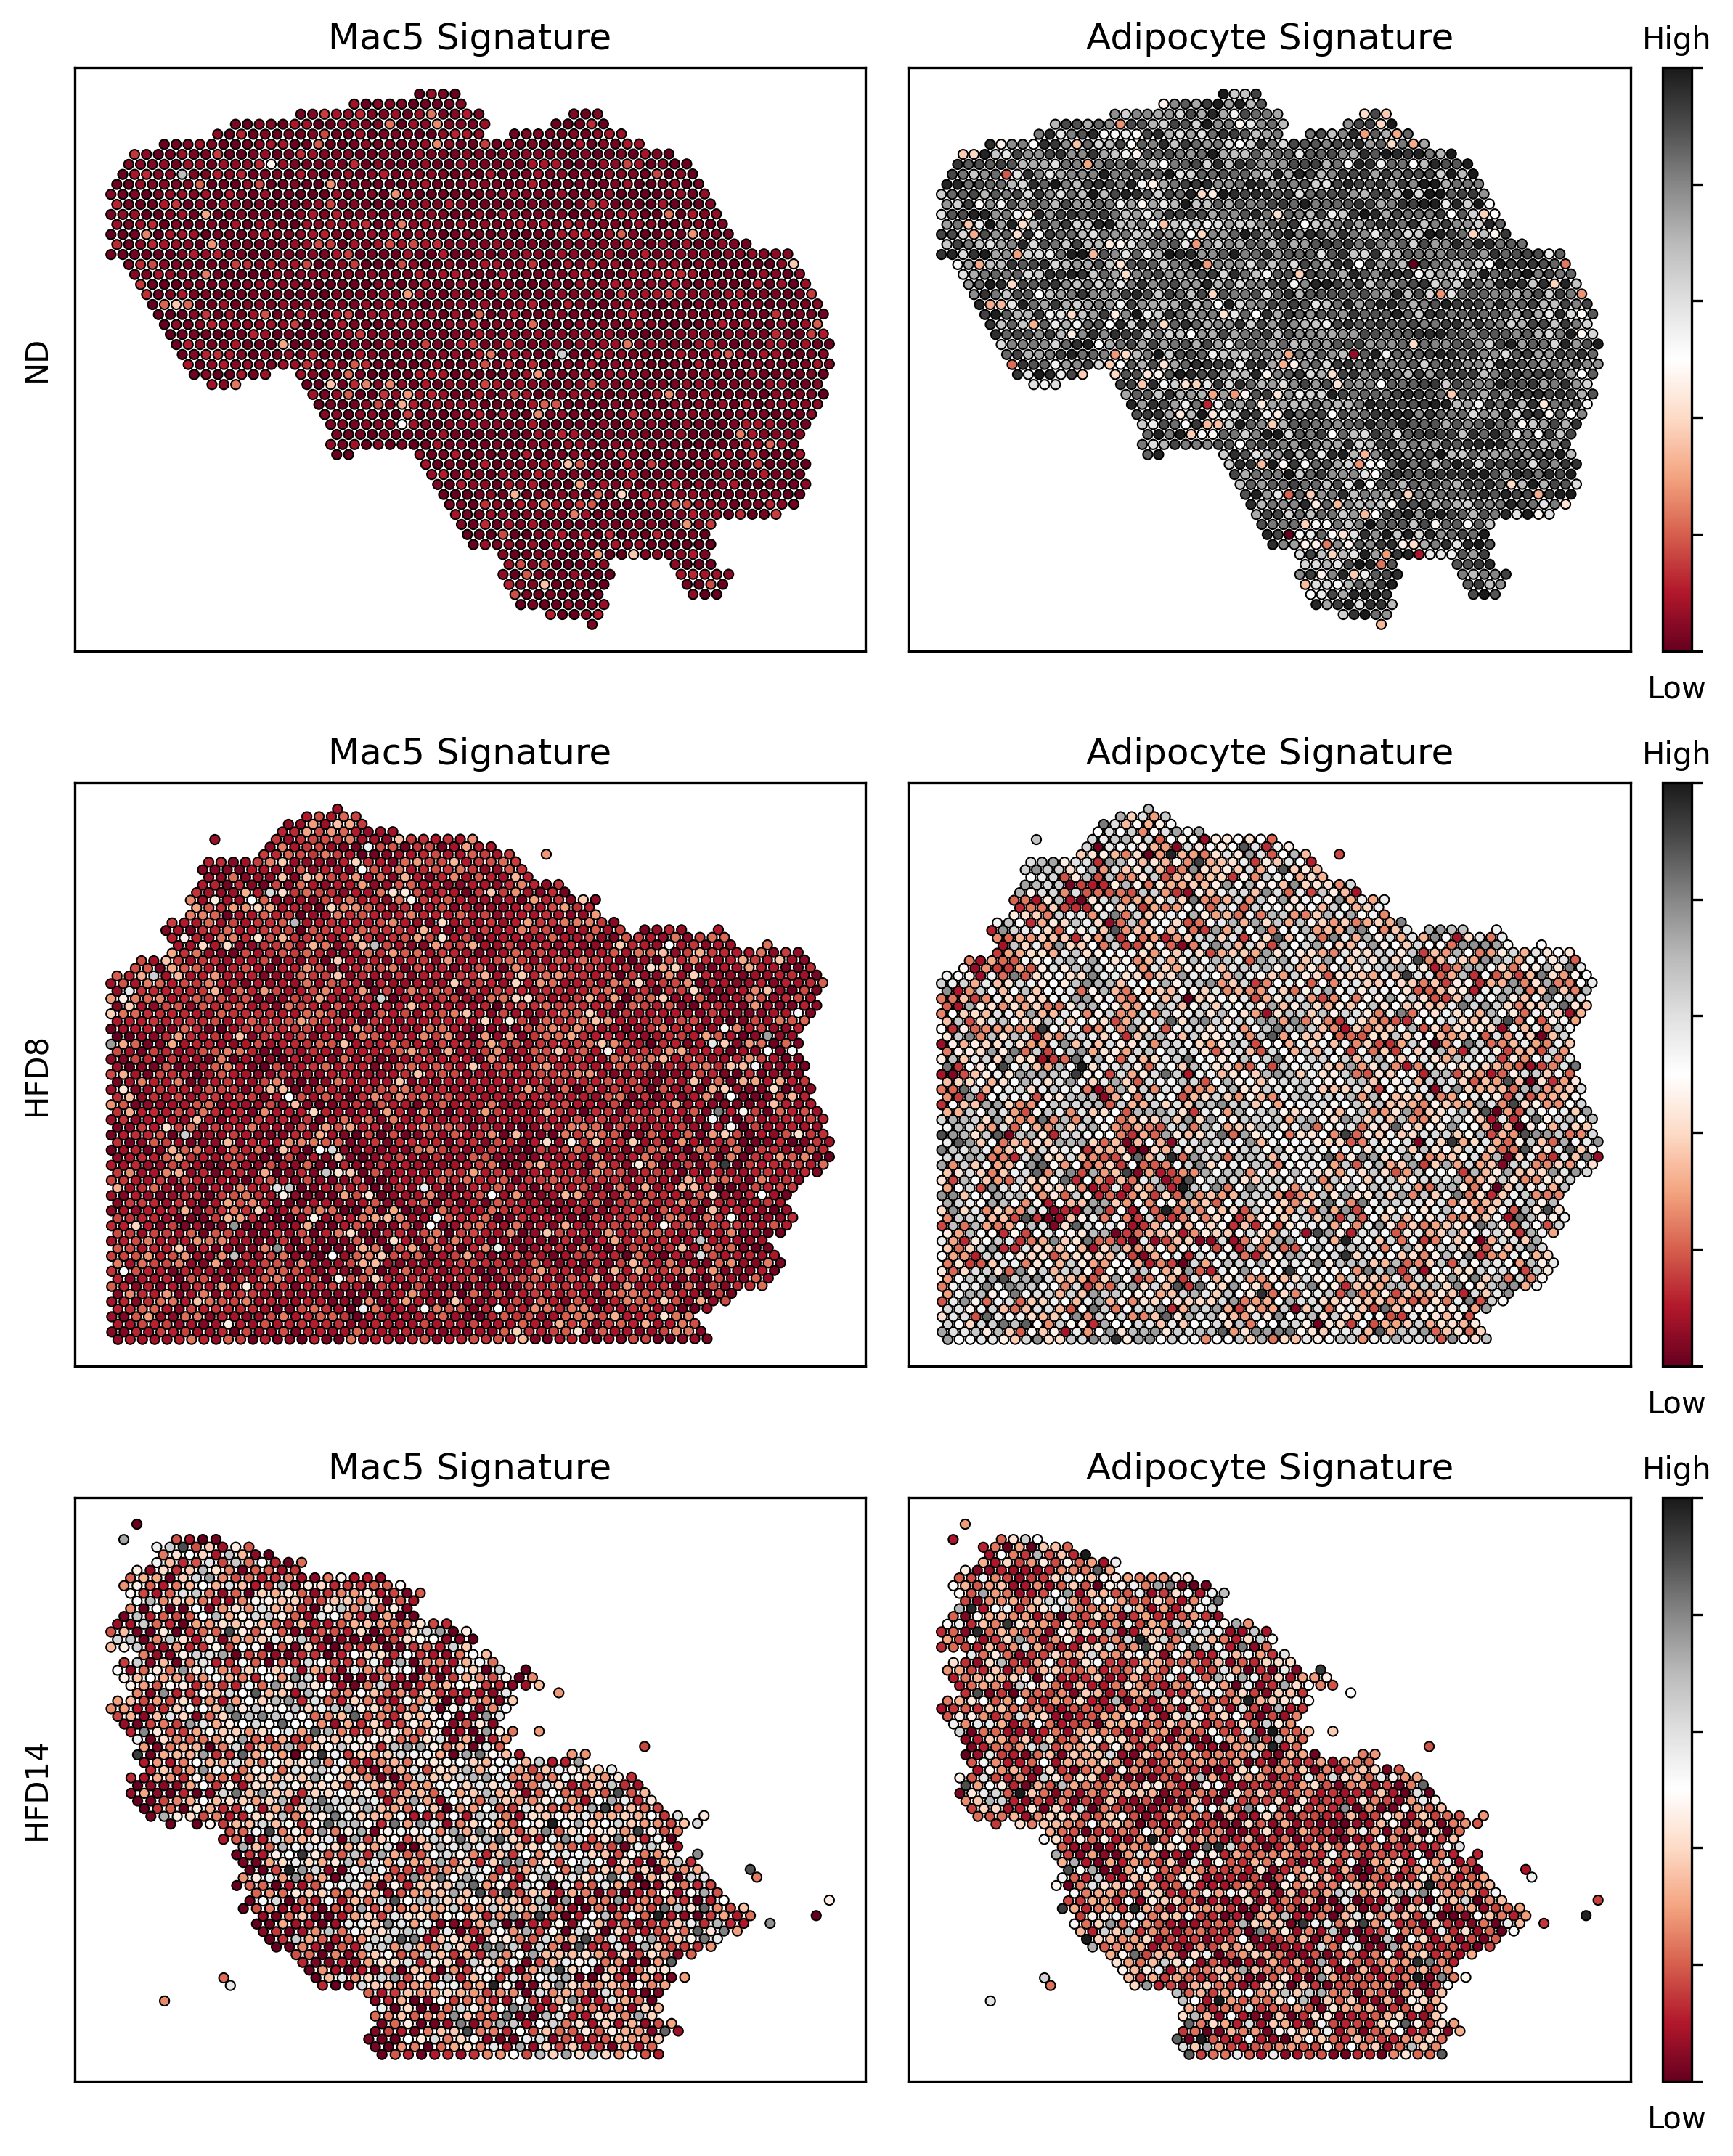

In [45]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 8, 10

fig, axs = plt.subplots(3, 2)

c1 = 'Mac5'
c2 = 'Stromal cells'

cmap = "RdGy_r"

keys = ['ND', 'HFD8', 'HFD14']


for i, key in enumerate(keys):
    kdf = df[df['key'] == key].reset_index(drop=True)
            
    axs[i, 0].scatter(kdf['x'].to_list(), 
                      kdf['y'].to_list(), 
                      c=kdf[c1],
                      ec='k', 
                      cmap=cmap,
                      vmin=0, 
                      vmax=1,
                      lw=0.5,
                      s=10)
    
    axs[i, 0].invert_yaxis()
    axs[i, 0].set_title(f"{c1} Signature")
    axs[i, 0].set_ylabel(f"{key}")
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])

    axs[i, 1].scatter(kdf['x'].to_list(), 
                      kdf['y'].to_list(), 
                      c=kdf[c2],
                      ec='k', 
                      cmap=cmap,
                      vmin=0, 
                      vmax=1,
                      lw=0.5,
                      s=10)
    
    axs[i, 1].invert_yaxis()
    # axs[i, 1].set_title(f"{c2} Signature")
    axs[i, 1].set_title(f"Adipocyte Signature")
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    
    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar  = plt.colorbar(sm, 
                     ax=axs[i, 1], 
                     fraction=0.046, 
                     pad=0.04)

    cbar.ax.set_yticklabels([])
    cbar.ax.set_title('High', fontsize=10)
    cbar.ax.set_xlabel('Low', fontsize=10)
    
plt.tight_layout()